In [230]:
### Package Imports 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import dmba
from dmba import regressionSummary, gainsChart, liftChart, classificationSummary
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import exhaustive_search
from dmba import stepwise_selection, forward_selection, backward_elimination
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import itertools
from sklearn.metrics.pairwise import haversine_distances
from math import radians

%matplotlib inline

In [231]:
rent = pd.read_csv('House_Rent_Dataset.csv')

### Data cleanup will entail splitting dates and addressing categorical variables
rent.head()

Posted On  BHK   Rent  Size            Floor    Area Type  \
0  2022-05-18    2  10000  1100  Ground out of 2   Super Area   
1  2022-05-13    2  20000   800       1 out of 3   Super Area   
2  2022-05-16    2  17000  1000       1 out of 3   Super Area   
3  2022-07-04    2  10000   800       1 out of 2   Super Area   
4  2022-05-09    2   7500   850       1 out of 2  Carpet Area   

              Area Locality     City Furnishing Status  Tenant Preferred  \
0                    Bandel  Kolkata       Unfurnished  Bachelors/Family   
1  Phool Bagan, Kankurgachi  Kolkata    Semi-Furnished  Bachelors/Family   
2   Salt Lake City Sector 2  Kolkata    Semi-Furnished  Bachelors/Family   
3               Dumdum Park  Kolkata       Unfurnished  Bachelors/Family   
4             South Dum Dum  Kolkata       Unfurnished         Bachelors   

   Bathroom Point of Contact  
0         2    Contact Owner  
1         1    Contact Owner  
2         1    Contact Owner  
3         1    Contact Owner  
4         1    Contact Owner

In [232]:
### Splitting train and test sets before preprocessing
train, test = train_test_split(rent, test_size = 0.3, random_state = 33)

### Train set predictors & Response
X_train = train.drop('Rent', axis = 1)
y_train = train['Rent']

### Test set predictors & Response
X_test = test.drop('Rent', axis = 1)
y_test = test['Rent']

print('\nTraining Set Length:', len(train))
print('\nTesting Set Length:', len(test))


Training Set Length: 3322

Testing Set Length: 1424


The dataset has been split 70/30 train/test and now has been split between predictors and reponse variables before moving into EDA and preprocessing. 

In [233]:
### There are no null values to fill
X_train.isna().sum()

Posted On            0
BHK                  0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

In [234]:
Floor_On = []
for i in range(0, len(X_train)):
    Floor_On.append(X_train.iloc[i].Floor[:2])
X_train[['Floor On']] = Floor_On


Floor_tot = []
for i in range(0, len(X_train)):
    Floor_tot.append(X_train.iloc[i].Floor[-2:])
X_train[['Floor total']] = Floor_tot

The above for loops extract the numerical values from the Floor predictor creating two predictors that represent the floors the individual is on and the total floors in the building. 

In the UK and India, the ground floor is referred to as the first floor in the U.S. and first floor in the UK and India is the second floor in the U.S..

Therefore, ground floor must be made into 0 and basement has been made into -1.

In [235]:
X_train[['Floor On']] = X_train[['Floor On']].replace('Gr', '0')
X_train[['Floor On']] = X_train[['Floor On']].replace('Up', '-1')
X_train[['Floor On']] = X_train[['Floor On']].replace('Lo', '-2')

X_train[['Floor total']] = X_train[['Floor total']].replace('nd', '0')

In [236]:
Floor_Ont = []
for i in range(0, len(X_test)):
    Floor_Ont.append(X_test.iloc[i].Floor[:2])
X_test[['Floor On']] = Floor_Ont


Floor_tott = []
for i in range(0, len(X_test)):
    Floor_tott.append(X_test.iloc[i].Floor[-2:])
X_test[['Floor total']] = Floor_tott

In [237]:
X_test[['Floor On']] = X_test[['Floor On']].replace('Gr', '0')
X_test[['Floor On']] = X_test[['Floor On']].replace('Up', '-1')
X_test[['Floor On']] = X_test[['Floor On']].replace('Lo', '-2')

X_train[['Floor total']] = X_train[['Floor total']].replace('nd', '0')

In [238]:
### Convert obj to datetime
X_train[['Posted On']] = pd.to_datetime(X_train['Posted On'])
X_train[['month']] = X_train['Posted On'].dt.month
X_train[['year']] = X_train['Posted On'].dt.year
X_train[['DOW']] = X_train['Posted On'].dt.dayofweek

X_test[['Posted On']] = pd.to_datetime(X_test['Posted On'])
X_test[['month']] = X_test['Posted On'].dt.month
X_test[['DOW']] = X_test['Posted On'].dt.dayofweek
X_test[['year']] = X_test['Posted On'].dt.year

X_train.head()

Posted On  BHK  Size            Floor    Area Type  \
1698 2022-06-04    2  1000       3 out of 4   Super Area   
3924 2022-05-10    2   200  Ground out of 1  Carpet Area   
4375 2022-05-24    2  1200       2 out of 2   Super Area   
3910 2022-06-10    2  1140       3 out of 4   Super Area   
3864 2022-05-16    2  1000       2 out of 3   Super Area   

                            Area Locality       City Furnishing Status  \
1698                         Bommanahalli  Bangalore    Semi-Furnished   
3924                           Dammaiguda  Hyderabad       Unfurnished   
4375  Beeramguda, Ramachandra Puram, NH 9  Hyderabad       Unfurnished   
3910                             Nizampet  Hyderabad    Semi-Furnished   
3864                  Chromepet, GST Road    Chennai       Unfurnished   

      Tenant Preferred  Bathroom Point of Contact Floor On Floor total  month  \
1698  Bachelors/Family         2    Contact Owner       3            4      6   
3924         Bachelors         2    Contact Owner        0           1      5   
4375         Bachelors         2    Contact Owner       2            2      5   
3910  Bachelors/Family         2    Contact Owner       3            4      6   
3864  Bachelors/Family         2    Contact Owner       2            3      5   

      year  DOW  
1698  2022    5  
3924  2022    1  
4375  2022    1  
3910  2022    4  
3864  2022    0

In [239]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3322 entries, 1698 to 2439
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Posted On          3322 non-null   datetime64[ns]
 1   BHK                3322 non-null   int64         
 2   Size               3322 non-null   int64         
 3   Floor              3322 non-null   object        
 4   Area Type          3322 non-null   object        
 5   Area Locality      3322 non-null   object        
 6   City               3322 non-null   object        
 7   Furnishing Status  3322 non-null   object        
 8   Tenant Preferred   3322 non-null   object        
 9   Bathroom           3322 non-null   int64         
 10  Point of Contact   3322 non-null   object        
 11  Floor On           3322 non-null   object        
 12  Floor total        3322 non-null   object        
 13  month              3322 non-null   int64         
 14  year 

In [240]:
X_train[['Floor On', 'Floor total']] = X_train[['Floor On', 'Floor total']].astype(int)

In [241]:
### Creating dummy variables for the train set
areatype_df = pd.get_dummies(X_train['Area Type'])
city_df = pd.get_dummies(X_train['City'])
furnish_df = pd.get_dummies(X_train['Furnishing Status'])
tenant_df = pd.get_dummies(X_train['Tenant Preferred'])
poc_df = pd.get_dummies(X_train['Point of Contact'])

### Creating dummy variables dataset
dummy_df = pd.concat([areatype_df, 
                      pd.concat([city_df, 
                                 pd.concat([furnish_df, poc_df], 
                                           axis = 1)], 
                                axis = 1)], 
                     axis = 1)


### Creating dummy variables for the test set
areatype_dft = pd.get_dummies(X_test['Area Type'])
city_dft = pd.get_dummies(X_test['City'])
furnish_dft = pd.get_dummies(X_test['Furnishing Status'])
tenant_dft = pd.get_dummies(X_test['Tenant Preferred'])
poc_dft = pd.get_dummies(X_test['Point of Contact'])

### Creating dummy variables dataset
dummy_dft = pd.concat([areatype_dft, 
                      pd.concat([city_dft, 
                                 pd.concat([furnish_dft, poc_dft], 
                                           axis = 1)], 
                                axis = 1)], 
                     axis = 1)

dummy_df.head()

Built Area  Carpet Area  Super Area  Bangalore  Chennai  Delhi  \
1698           0            0           1          1        0      0   
3924           0            1           0          0        0      0   
4375           0            0           1          0        0      0   
3910           0            0           1          0        0      0   
3864           0            0           1          0        1      0   

      Hyderabad  Kolkata  Mumbai  Furnished  Semi-Furnished  Unfurnished  \
1698          0        0       0          0               1            0   
3924          1        0       0          0               0            1   
4375          1        0       0          0               0            1   
3910          1        0       0          0               1            0   
3864          0        0       0          0               0            1   

      Contact Agent  Contact Owner  
1698              0              1  
3924              0              1  
4375              0              1  
3910              0              1  
3864              0              1

In [242]:
### concating the training set with the dummy variables 
X_train1 = pd.concat([X_train, dummy_df], axis = 1)

### concating the testing set with the dummy variables 
X_test1 = pd.concat([X_test, dummy_dft], axis = 1)

X_train1.head()

Posted On  BHK  Size            Floor    Area Type  \
1698 2022-06-04    2  1000       3 out of 4   Super Area   
3924 2022-05-10    2   200  Ground out of 1  Carpet Area   
4375 2022-05-24    2  1200       2 out of 2   Super Area   
3910 2022-06-10    2  1140       3 out of 4   Super Area   
3864 2022-05-16    2  1000       2 out of 3   Super Area   

                            Area Locality       City Furnishing Status  \
1698                         Bommanahalli  Bangalore    Semi-Furnished   
3924                           Dammaiguda  Hyderabad       Unfurnished   
4375  Beeramguda, Ramachandra Puram, NH 9  Hyderabad       Unfurnished   
3910                             Nizampet  Hyderabad    Semi-Furnished   
3864                  Chromepet, GST Road    Chennai       Unfurnished   

      Tenant Preferred  Bathroom  ... Chennai  Delhi  Hyderabad  Kolkata  \
1698  Bachelors/Family         2  ...       0      0          0        0   
3924         Bachelors         2  ...       0      0          1        0   
4375         Bachelors         2  ...       0      0          1        0   
3910  Bachelors/Family         2  ...       0      0          1        0   
3864  Bachelors/Family         2  ...       1      0          0        0   

      Mumbai  Furnished  Semi-Furnished  Unfurnished  Contact Agent  \
1698       0          0               1            0              0   
3924       0          0               0            1              0   
4375       0          0               0            1              0   
3910       0          0               1            0              0   
3864       0          0               0            1              0   

      Contact Owner  
1698              1  
3924              1  
4375              1  
3910              1  
3864              1  

[5 rows x 30 columns]

In [243]:
### Year will be a zero variance variable and therefore can be dropped
X_train1[['year']].value_counts()

year
2022    3322
dtype: int64

In [244]:
X_train1[['Area Type']].value_counts()

Area Type  
Super Area     1688
Carpet Area    1632
Built Area        2
dtype: int64

In [245]:
X_train1[['City']].value_counts()

City     
Mumbai       707
Chennai      624
Bangalore    613
Hyderabad    593
Delhi        424
Kolkata      361
dtype: int64

In [246]:
X_train1[['Tenant Preferred']].value_counts()

Tenant Preferred
Bachelors/Family    2392
Bachelors            586
Family               344
dtype: int64

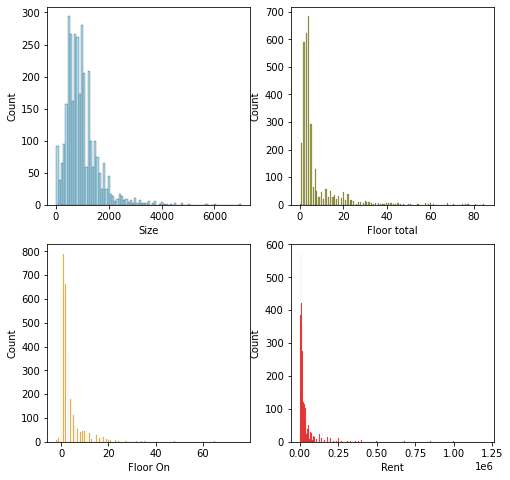

In [247]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
sns.histplot(X_train1["Size"] , color="skyblue", ax=axes[0,0])
sns.histplot(X_train1["Floor total"] , color="olive", ax=axes[0,1])
sns.histplot(X_train1["Floor On"] , color="orange", ax=axes[1,0])
sns.histplot(y_train , color="red", ax=axes[1,1])
plt.show()

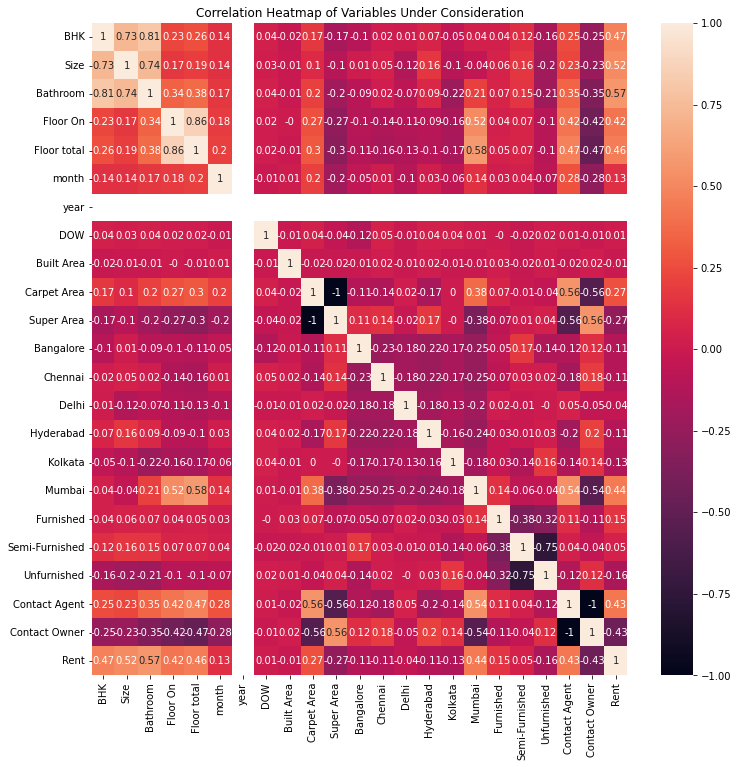

In [248]:
matrix = pd.concat([X_train1, y_train], axis = 1).corr().round(2)
plt.figure(figsize=(12,12))
sns.heatmap(matrix, annot=True)
plt.title('Correlation Heatmap of Variables Under Consideration')
plt.show()

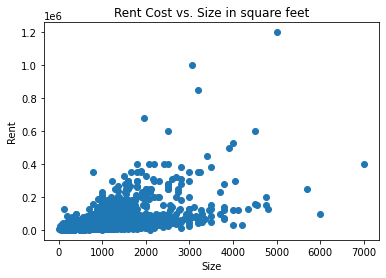

In [249]:
plt.scatter(x = X_train1['Size'], y = y_train)
plt.title('Rent Cost vs. Size in square feet')
plt.xlabel('Size')
plt.ylabel('Rent')
plt.show()

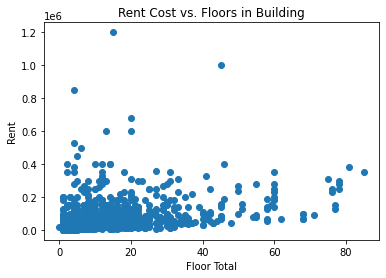

In [252]:
plt.scatter(x = X_train1['Floor total'], y = y_train)
plt.title('Rent Cost vs. Floors in Building')
plt.xlabel('Floor Total')
plt.ylabel('Rent')
plt.show()

In [253]:
Xmod_train = X_train1.drop(['Posted On','Floor','Area Type',
                           'Area Locality','City','Furnishing Status',
                           'Tenant Preferred','year','Point of Contact'], axis = 1)

Xmod_test = X_test1.drop(['Posted On','Floor','Area Type',
                           'Area Locality','City','Furnishing Status',
                           'Tenant Preferred','year','Point of Contact'], axis = 1)

Xmod_train.head()

BHK  Size  Bathroom  Floor On  Floor total  month  DOW  Built Area  \
1698    2  1000         2         3            4      6    5           0   
3924    2   200         2         0            1      5    1           0   
4375    2  1200         2         2            2      5    1           0   
3910    2  1140         2         3            4      6    4           0   
3864    2  1000         2         2            3      5    0           0   

      Carpet Area  Super Area  ...  Chennai  Delhi  Hyderabad  Kolkata  \
1698            0           1  ...        0      0          0        0   
3924            1           0  ...        0      0          1        0   
4375            0           1  ...        0      0          1        0   
3910            0           1  ...        0      0          1        0   
3864            0           1  ...        1      0          0        0   

      Mumbai  Furnished  Semi-Furnished  Unfurnished  Contact Agent  \
1698       0          0               1            0              0   
3924       0          0               0            1              0   
4375       0          0               0            1              0   
3910       0          0               1            0              0   
3864       0          0               0            1              0   

      Contact Owner  
1698              1  
3924              1  
4375              1  
3910              1  
3864              1  

[5 rows x 21 columns]